Alumno: Federico Arias Suarez

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.
- Probar términos de interés y explicar similitudes en el espacio de embeddings (sacar conclusiones entre palabras similitudes y diferencias).
- Graficarlos.
- Obtener conclusiones.

Para resolver este desafio vamos a instalar la libreria `datasets` de huggingFace, vamos a usar el dataset denominado 'empathetic dialogues'.

El mismo contiene conversaciones entre un 'listener' y un 'speaker' en el cual cada uno debe comentar sus emociones.

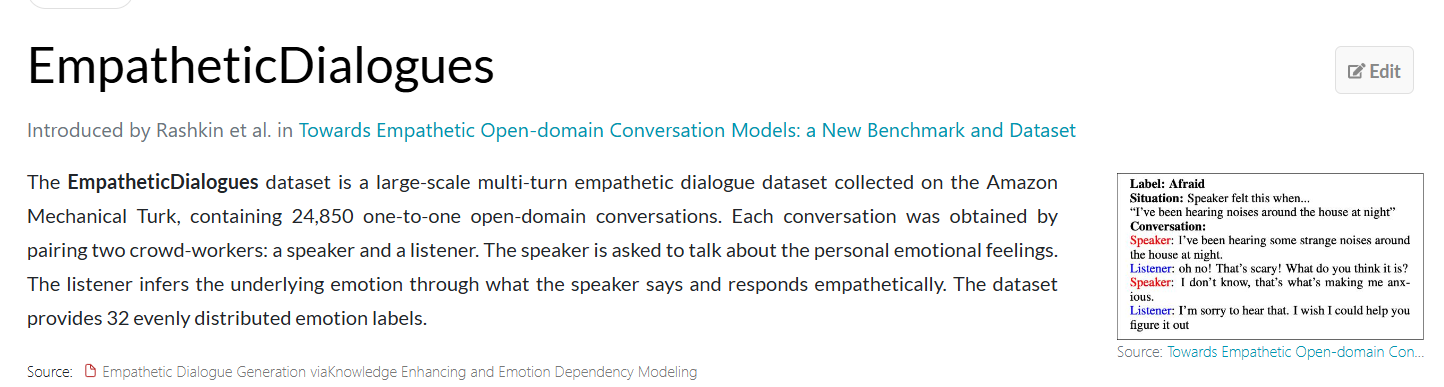

In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
from gensim.models import Word2Vec
from datasets import load_dataset

dataset = load_dataset("empathetic_dialogues")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.15k [00:00<?, ?B/s]

empathetic_dialogues.py:   0%|          | 0.00/4.51k [00:00<?, ?B/s]

The repository for empathetic_dialogues contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/empathetic_dialogues.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/76673 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/12030 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10943 [00:00<?, ? examples/s]

In [ ]:
len(dataset['train'])  #Parece suficiente

76673

In [ ]:
#Ejemplo de una oracion
dataset['train'][0]['prompt']

'I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world.'

In [ ]:
#VAmos a crear un dataframe con todas las oraciones:
# Extraer todas las oraciones de 'prompt' del dataset y guardamos con dataframe
df = pd.DataFrame(dataset['train']['prompt'], columns=["prompt"])
df.drop_duplicates(inplace=True)
df.shape

(17578, 1)

In [ ]:
df.sample(3)

,prompt
46690,I went out of town the other day and went out ...
39308,I am going to a party later tonight. I think t...
43073,I am going horseback riding for the first time...


# Para el preprocesamiento

In [ ]:
#La coma figura como _comma_ la vamos a remplazar por ''
df['prompt'] = df['prompt'].str.replace('_comma_', '')

Para preprocesar el texto, vamos a usar la libreria `natural_language_toolkit`

In [ ]:
!pip install nltk


In [ ]:
#En esta celda acplicamos el preprocesamiento
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import string

# Descargar recursos de NLTK
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download('omw-1.4')

# Instancias de stemmer y lemmatizer
p_stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

# Función de preprocesamiento
def nltk_process(text):
    # Tokenización
    tokens = word_tokenize(text.lower())

    # Lematización
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Filtrado de stopwords y puntuación
    filtered_sentence = [w for w in lemmatized_tokens if w not in stop_words and w not in string.punctuation]

    return filtered_sentence

# Aplicar la función a cada oración en el DataFrame
df['processed_prompt'] = df['prompt'].apply(nltk_process)

# Convertimos las sentencias procesadas en una lista de palabraspara entrenar el modelo
sentence_tokens = df['processed_prompt'].tolist()

# Muestra el DataFrame con la nueva columna
df[['prompt', 'processed_prompt']].head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,prompt,processed_prompt
0,I remember going to the fireworks with my best...,"[remember, going, firework, best, friend, wa, ..."
6,i used to scare for darkness,"[used, scare, darkness]"
12,I showed a guy how to run a good bead in weldi...,"[showed, guy, run, good, bead, welding, class,..."
17,I have always been loyal to my wife.,"[always, loyal, wife]"
21,A recent job interview that I had made me feel...,"[recent, job, interview, made, feel, anxious, ..."


In [ ]:
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

# Callback para imprimir la pérdida al final de cada época
class callback(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
        self.loss_previous_step = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        print('Loss after epoch {}: {}'.format(self.epoch, loss - self.loss_previous_step))
        self.loss_previous_step = loss
        self.epoch += 1

'# Función de preprocesamiento\nnltk.download("stopwords")\nstop_words = set(stopwords.words("english"))\n\ndef nltk_process(text):\n    tokens = word_tokenize(text.lower())\n    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]\n    filtered_sentence = [w for w in lemmatized_tokens if w not in stop_words and w not in string.punctuation]\n    return filtered_sentence\n\n# Aplicar la función de preprocesamiento y obtener tokens\ndf[\'processed_prompt\'] = df[\'prompt\'].apply(nltk_process)\nsentence_tokens = df[\'processed_utterance\'].tolist()'

# Entrenamiento de los embeddings

In [ ]:
# Crear y configurar el modelo Word2Vec
w2v_model = Word2Vec(
    min_count=3,    # frecuencia mínima para incluir palabras en el vocabulario
    window=4,       # cantidad de palabras en contexto
    vector_size=200,# dimensionalidad de los vectores
    negative=10,    # número de "negative samples"
    workers=1,      # número de núcleos de CPU
    sg=1            # 1 para skip-gram, 0 para CBOW
)

# Construir el vocabulario
w2v_model.build_vocab(sentence_tokens)

# Entrenar el modelo usando el callback
w2v_model.train(
    sentence_tokens,
    total_examples=w2v_model.corpus_count,
    epochs=30,
    compute_loss=True,
    callbacks=[callback()]
)

Loss after epoch 0: 1942803.75
Loss after epoch 1: 1393596.75
Loss after epoch 2: 1253396.5
Loss after epoch 3: 1106916.0
Loss after epoch 4: 1101436.5
Loss after epoch 5: 1092888.0
Loss after epoch 6: 1036410.5
Loss after epoch 7: 983420.0
Loss after epoch 8: 973617.0
Loss after epoch 9: 961974.0
Loss after epoch 10: 956112.0
Loss after epoch 11: 945568.0
Loss after epoch 12: 939115.0
Loss after epoch 13: 926145.0
Loss after epoch 14: 922671.0
Loss after epoch 15: 860966.0
Loss after epoch 16: 836012.0
Loss after epoch 17: 830844.0
Loss after epoch 18: 822332.0
Loss after epoch 19: 813746.0
Loss after epoch 20: 806866.0
Loss after epoch 21: 799736.0
Loss after epoch 22: 794138.0
Loss after epoch 23: 788228.0
Loss after epoch 24: 784216.0
Loss after epoch 25: 778672.0
Loss after epoch 26: 775080.0
Loss after epoch 27: 769450.0
Loss after epoch 28: 769916.0
Loss after epoch 29: 765596.0


(3893660, 4801860)

# Probamos los embeddings por similitud con alguna palabra

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["happy"], topn=10)

[('joyful', 0.48359665274620056),
 ('happiest', 0.4776235818862915),
 ('loving', 0.46875208616256714),
 ('freedom', 0.42881301045417786),
 ('healthy', 0.42253875732421875),
 ('content', 0.4186093211174011),
 ('6th', 0.41633185744285583),
 ('retired', 0.41478830575942993),
 ('artist', 0.4068279266357422),
 ('considerate', 0.4064495861530304)]

Para la palabra happy: es intereante ver como el modelo de NLP la vincula con palabras como joyful, freedom, healthy y considerate. Lo cual hace sentido.

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["christmas"], topn=10)

[('eve', 0.5876252055168152),
 ('waking', 0.4845607876777649),
 ('holiday', 0.4623824656009674),
 ('twelve', 0.45913898944854736),
 ('22', 0.45579272508621216),
 ('80', 0.44258925318717957),
 ('inch', 0.44041216373443604),
 ('happiest', 0.4377266764640808),
 ('thanksgiving', 0.43618518114089966),
 ('fond', 0.43369346857070923)]

Para la palabra Christmass: es intereante ver como el modelo de NLP la vincula con palabras como eve, holiday, happiest y thanksgiving (como que entendio que ambos son feriados).

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["sad"], topn=10)

[('williams', 0.4939574599266052),
 ('devestated', 0.49178266525268555),
 ('saddened', 0.49140703678131104),
 ('robin', 0.4721299707889557),
 ('emotional', 0.45468422770500183),
 ('devasted', 0.45372191071510315),
 ('heartbroken', 0.4495416581630707),
 ('depressing', 0.44660264253616333),
 ('tragic', 0.44443944096565247),
 ('shaken', 0.442343145608902)]

Para la palabra sad: es intereante ver como el modelo de NLP la vincula con palabras como devestated, saddened, devasted, heartbroken, depressing, tragic y shaking. Lo que no es claro, es por que vincula a Williams.

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["insecure"], topn=10)

[('hopeless', 0.6690021753311157),
 ('enthusiastic', 0.6464784741401672),
 ('remorse', 0.6281798481941223),
 ('uncomfortable', 0.6218060255050659),
 ('trauma', 0.6207271218299866),
 ('matched', 0.6186689138412476),
 ('isolated', 0.613548994064331),
 ('overwhelming', 0.5865111351013184),
 ('environment', 0.5856361985206604),
 ('achievement', 0.5724723935127258)]

Para la palabra insecure: es intereante ver como el modelo de NLP la vincula con palabras como hopelss, remorse, uncomfortable, trauma, isolated, overwhelming.

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["stomach"], topn=10)

[('butterfly', 0.6142812967300415),
 ('mentally', 0.5690581798553467),
 ('clinton', 0.5676465630531311),
 ('strep', 0.5527063608169556),
 ('diabetes', 0.544770359992981),
 ('hillary', 0.5387395620346069),
 ('nursed', 0.5302636623382568),
 ('vomiting', 0.5302022695541382),
 ('dr', 0.5293211340904236),
 ('researched', 0.5287793874740601)]

Para la palabra stomach (se dice que es el `cerebro` de las emociones): es intereante ver como el modelo de NLP la vincula con palabras como butterfly, mentally, diabetes, vomiting, dr. Quizas no capto que las emociones se `sienten` en el estomago, es una relacion muy rebuscada, pero igual algunas palabras estan relacionadas.

In [ ]:
#Ahora dibujaremos el grafico en 2D de las palabras mas relacionadas
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np

def reduce_dimensions(model, num_dimensions = 2 ):

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [ ]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

Algunas relaciones interesantes se ve que:
- girlfriend y wife estan cerca (coordenadas x=-10; y=10) con boyfriend un poco mas abajo.
- Money y pay (coordenadas x=7.5, y=27)
- birthday y party (coordenadas x=-27.5, y= -26)
- mom, brother y doughter (coordenadas: x=-2.8, y=-8.2)

In [ ]:
# Términos de interés relacionados a emociones
terms_of_interest = ["happy", "sad", "angry", "joy", "fear", 'guilty',
                     'insecure', 'surprised', 'anger', 'disgust', 'nervous']

# Encontrar palabras similares
for term in terms_of_interest:
    print(f"\nPalabras similares a '{term}':")
    similar_words = w2v_model.wv.most_similar(positive=[term], topn=5)
    for word, similarity in similar_words:
        print(f"  {word}: {similarity:.4f}")



Palabras similares a 'happy':
  joyful: 0.4836
  happiest: 0.4776
  loving: 0.4688
  freedom: 0.4288
  healthy: 0.4225

Palabras similares a 'sad':
  williams: 0.4940
  devestated: 0.4918
  saddened: 0.4914
  robin: 0.4721
  emotional: 0.4547

Palabras similares a 'angry':
  mad: 0.4879
  pissed: 0.4746
  irked: 0.4697
  incompetent: 0.4456
  comment: 0.4443

Palabras similares a 'joy':
  blessing: 0.6575
  overcome: 0.6404
  fond: 0.6287
  joyful: 0.6216
  mixed: 0.6147

Palabras similares a 'fear':
  height: 0.5522
  overcome: 0.5489
  tandem: 0.5293
  escargot: 0.5188
  bungee: 0.4970

Palabras similares a 'guilty':
  remorse: 0.5742
  forgetting: 0.5480
  piggy: 0.5462
  overslept: 0.5002
  somewhat: 0.4945

Palabras similares a 'insecure':
  hopeless: 0.6690
  enthusiastic: 0.6465
  remorse: 0.6282
  uncomfortable: 0.6218
  trauma: 0.6207

Palabras similares a 'surprised':
  pleasantly: 0.5389
  shocked: 0.4433
  british: 0.4382
  impromptu: 0.4372
  juggle: 0.4277

Palabras simi

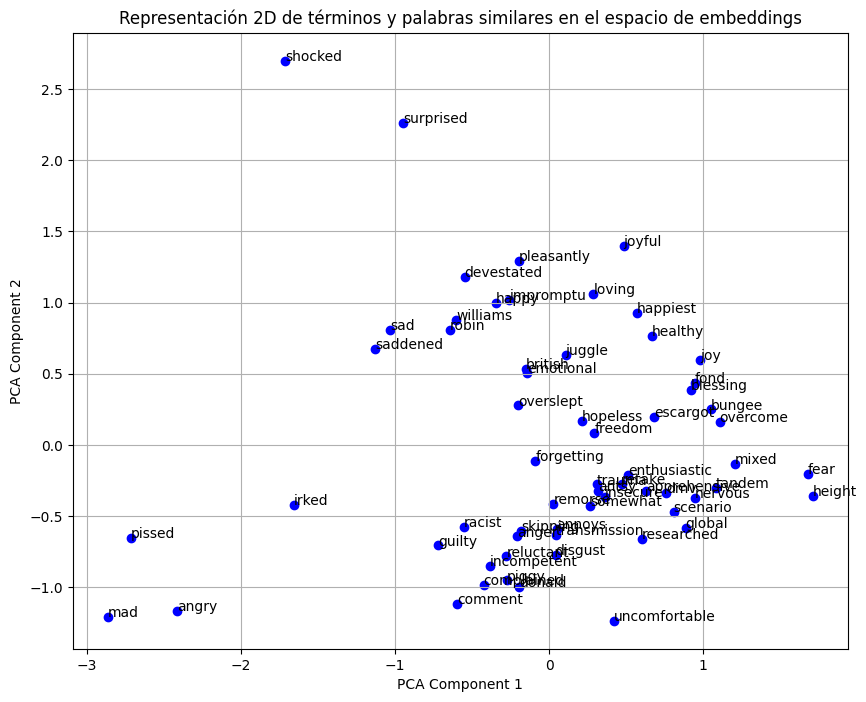

In [ ]:
#Ahora vamos a hacer un grafico 2D para las palabras de interes anteriormente difinidas:

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Obtener los vectores de términos de interés y sus palabras similares
words = terms_of_interest.copy()
for term in terms_of_interest:
    similar_words = w2v_model.wv.most_similar(positive=[term], topn=5)
    words.extend([word for word, _ in similar_words])

# Eliminar duplicados
words = list(set(words))

# Obtener los vectores
word_vectors = np.array([w2v_model.wv[word] for word in words])

# Reducir dimensionalidad a 2D con PCA
pca = PCA(n_components=2)
word_vectors_2d = pca.fit_transform(word_vectors)

# Graficar los términos
plt.figure(figsize=(10, 8))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], color='blue')

for i, word in enumerate(words):
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]))

plt.title("Representación 2D de términos y palabras similares en el espacio de embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()


Algunas relaciones interesantes:
- shocked y surprised
- pissed, mad y angry
- joyful, loving, happiest, healthy
- fear, height, scenario

# Test de analogias: Sumar y restar vectores embeddings de palabras

In [ ]:
# Definir las combinaciones para explorar sumas y restas de vectores
combinations = [
    ("happy", "surprised", "add"),    # happy + surprised
    ("angry", "anxiety", "add"), # angry - surprised
    ("fear", "sad", "add"),
    ("alone", "sad", "add"),
    ("july", "happy", "add"),
    ("happy", "surprised", "subtract"),
    ("angry", "anxiety", "subtract"), # angry - anxiety
    ("fear", "sad", "subtract"), # angry - anxiety
    ("alone", "angry", "subtract"), # angry - anxiety
]

# Función para realizar la operación y mostrar resultados
def explore_vector_operations(combinations):
    for word1, word2, operation in combinations:
        if operation == "add":
            result = w2v_model.wv[word1] + w2v_model.wv[word2]
            operation_text = f"{word1} + {word2}"
        elif operation == "subtract":
            result = w2v_model.wv[word1] - w2v_model.wv[word2]
            operation_text = f"{word1} - {word2}"

        # Encontrar palabras más similares al resultado
        similar_words = w2v_model.wv.similar_by_vector(result, topn=5)

        print(f"\nOperación: {operation_text}")
        for word, similarity in similar_words[2:]:   #Las primeras dos mas parecidas son las mismas dos del input
            print(f"  {word}: {similarity:.4f}")

# Ejecutar las operaciones
explore_vector_operations(combinations)



Operación: happy + surprised
  joyful: 0.5281
  pleasantly: 0.5206
  impromptu: 0.5112

Operación: angry + anxiety
  incompetent: 0.5778
  loneliness: 0.5730
  lack: 0.5706

Operación: fear + sad
  depressing: 0.5684
  prefer: 0.5385
  devestated: 0.5301

Operación: alone + sad
  lonesome: 0.6090
  depressing: 0.5684
  saddened: 0.5556

Operación: july + happy
  4th: 0.6673
  celebration: 0.6121
  august: 0.6044

Operación: happy - surprised
  whenever: 0.1866
  homework: 0.1761
  accomplished: 0.1716

Operación: angry - anxiety
  mercedes: 0.3020
  sole: 0.2919
  pissed: 0.2862

Operación: fear - sad
  height: 0.2615
  pilot: 0.2558
  nest: 0.2463

Operación: alone - angry
  searched: 0.2948
  prison: 0.2937
  lonesome: 0.2802


Vemos algunas combinaciones interesantes:
- happy + surprised = joyful, parece legitimo, porque el goce es una mezcla de felicidad y sorpresa.
- angry + anxiety = incompetente y loneliness. Puede ser interpretado de esa forma.
- fear + sad = depressing. Esta relacion es clara, miedo y tristeza es depresivo.
- alone + sad = depressing. Esta relacion es clara, miedo y tristeza es depresivo.
- july + happy: celebration.
- angry - anxiety: pissed. Enojado le resta ansiedad puede dar enfadado.

De las restas de palabras no tienen mucho sentido en la mayoría de los casos. Las adiciones de palabras sí tienen sentido en la mayoría de los ejemplos.